In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-swing-on-ball.csv")

df_balls = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

all_files = glob.glob("roll_data/*-swing-on-strike.csv")

df_strikes = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [2]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]# * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]# * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]# * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2/freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # traveling just doesn't do anything on pitchers?
        # if not row["top_of_inning"]:
            #mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        #mul += min(0.05, 0.05 * (row["day"] / 99))
        pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul

def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm:
        # todo: handle, in peanuts weather
        pass
    if "SMOOTH" in bm:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        pass
    return mul

In [3]:
# additions and corrections, global

df_balls["batter_mul"] = df_balls.apply(get_batter_mul, axis=1)
df_balls["pitcher_mul"] = df_balls.apply(get_pitcher_mul, axis=1)

df_balls.loc[df_balls["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
df_balls.loc[df_balls["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0


df_strikes["batter_mul"] = df_strikes.apply(get_batter_mul, axis=1)
df_strikes["pitcher_mul"] = df_strikes.apply(get_pitcher_mul, axis=1)

df_strikes.loc[df_strikes["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
df_strikes.loc[df_strikes["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

df_balls["ruth_scaled"] = df_balls["pitcher_ruthlessness"] * df_balls["pitcher_mul"]
df_balls["mox_scaled"] = df_balls["batter_moxie"] * df_balls["batter_mul"]
df_balls["path_scaled"] = 1 - ((1 - df_balls["batter_patheticism"]) * df_balls["batter_mul"])
df_balls["mox_path"] = df_balls["mox_scaled"] - df_balls["path_scaled"]

# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [4]:
# df = df[(df["batting_team_hype"] == 0) & (df['pitching_team_hype'] == 0)]

# df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * (1 + 0.2 * df_balls["pitcher_vibes"])
# df_balls["mox_vibes"] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls["mox_vibes"] = df_balls["mox_scaled"] * (1 + 0.2 * df_balls["batter_vibes"])
df_balls["path_vibes"] = 1 - ((1 - df_balls["path_scaled"]) * (1 + 0.2 * df_balls["batter_vibes"]))

# beiju's idea
df_balls["visc_filth"] = df_balls["ballpark_viscosity"] * df_balls["ballpark_filthiness"]
# # put in our "best fit" up here in the original df, just because
# df['svc_best'] = 0.30 * df["ruth_scaled"] + 0.20 * df["ballpark_forwardness"] \
#                   + 0.06 * df["ruth_vibes"] + 0.10 * df["musc_scaled"]

# kidror's idea
df_balls["ruth_sq"] = df_balls["ruth_vibes"]**2
df_balls["mox_sq"] = df_balls["mox_vibes"]**2
df_balls["path_sq"] = df_balls["path_scaled"]**2 # not path_vibes
df_balls["visc_sq"] = df_balls["ballpark_viscosity"]**2

In [5]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]

# just look at swinging on balls first
dfc = df_balls
for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH",
                    "SINKING_SHIP", "TRAVELING", "AFFINITY_FOR_CROWS", "CHUNKY", "SMOOTH", "ON_FIRE"]:
# for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    # exclude flinch situations entirely
    dfc = dfc[~((dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0))]

In [6]:
# print(list(df_balls.columns))
print(len(df_balls))
print(len(dfc))

55799
33776


In [7]:
digest_list = ["event_type", "roll", "batter_name", "pitcher_name",
               "ruth_scaled", "pitcher_vibes", "musc_scaled",
               "ballpark_forwardness", "game_id", "play_count", "svc_best"]

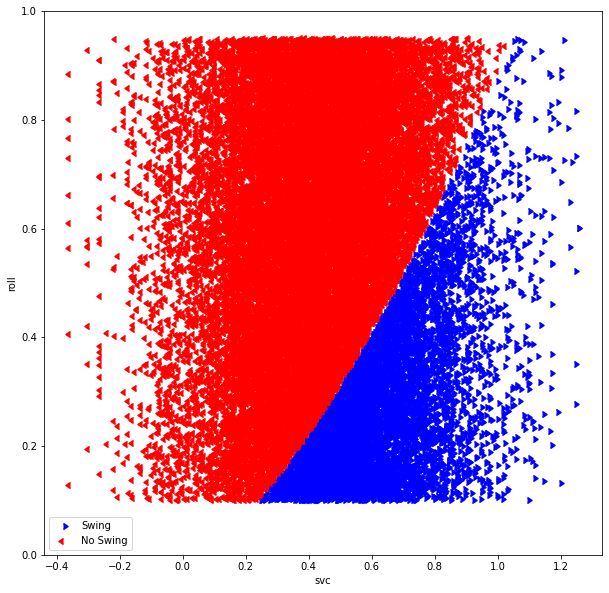

In [181]:
# x_val = "ruth_vibes"
x_val = "svc"
fig, ax = plt.subplots(1, figsize=(10,10))

ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red", label="No Swing", marker=CARETLEFTBASE)

# xline = np.array(ax.get_xlim())
# yline = -intercept_scaled + xline
# # yline = -0.2 + xline
# ax.plot(xline, yline, 'k')

ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_ylim(0, 1)
# ax.set_xlim(0.484, 0.499)

ax.legend()

# fig.savefig(x_val+".png", facecolor='white')

In [9]:
dfc[dfc["passed"] == True]["roll"].max()

0.9492693003761858

In [10]:
dfc[dfc["passed"] == False]["roll"].min()

0.0022923664988039

In [11]:
# max for swings seems to be 0.95 so remove rolls above that
dfc = dfc[dfc['roll'] < 0.95]
# weird "cutoff" at 0.1 (though you can take pitches below this!) so remove rolls below that
dfc = dfc[dfc['roll'] > 0.1]
len(dfc)

28806

In [12]:
dfc.groupby('batter_mul').head(1)[['batter_mul', 'batter_name']].sort_values(
    'batter_mul', ascending=False)[0:10]


,batter_mul,batter_name
0,1.0,Farrell Seagull


In [13]:
print(list(df_balls.columns))

['Unnamed: 0', 'event_type', 'roll', 'passed', 'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon', 'batter_multiplier', 'pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_contin

In [149]:
# X = dfc[['roll', *dfc.columns[5:-11]]].drop('pitcher_name', axis=1).drop('batter_mods', axis=1)\
#     .drop('batting_team_mods', axis=1).drop('pitching_team_mods', axis=1).drop('pitcher_mods', axis=1)\
#     .drop('batter_vibes', axis=1).drop('pitcher_vibes', axis=1)\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness', 'pitcher_vibes_multiplied', 'batter_musclitude']]

# X = dfc[['roll', *dfc.columns[4:-42], 'batter_vibes', 'pitcher_vibes']]\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'ruth_vibes', 'path_vibes', 'mox_vibes', 'ballpark_viscosity']]#, 'mox_path', 'visc_filth']]
# X = dfc[['passed', 'roll', 'ruth_scaled', 'ballpark_forwardness', 'ruth_vibes', 'musc_scaled', 'flinch']]
# X = X[X['roll'] < 0.85]
X = dfc[['roll', 'ruth_vibes', 'mox_vibes', 'path_scaled', 'ballpark_viscosity']]
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = dfc['passed']
# X = X.drop('passed', axis=1)

In [150]:
X

,roll,ruth_vibes,mox_vibes,path_scaled,ballpark_viscosity
0,0.134451,0.786526,1.011165,0.001000,0.263230
6,0.679864,0.786526,1.011165,0.001000,0.263230
8,0.614558,0.377605,0.404359,0.743872,0.481398
9,0.681459,0.786526,1.011165,0.001000,0.263230
10,0.185785,0.999588,0.789592,0.280326,0.432771
...,...,...,...,...,...
55792,0.359999,0.483102,0.549733,0.652489,0.469763
55794,0.138031,0.722749,0.971521,0.215902,0.469763
55795,0.420596,0.722749,0.631829,0.365844,0.469763
55796,0.360856,0.722749,0.631829,0.365844,0.469763


In [151]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=1000000, C=1000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y,predictionsvm))
print(classification_report(y,predictionsvm))

[[21689   156]
 [  163  6798]]
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     21845
        True       0.98      0.98      0.98      6961

    accuracy                           0.99     28806
   macro avg       0.99      0.98      0.98     28806
weighted avg       0.99      0.99      0.99     28806



In [152]:
sc.inverse_transform(trainedsvm.coef_)

array([[-1.5884065 ,  2.50887193, -0.46285208,  1.11411963,  0.52955442]])

In [153]:
trainedsvm.coef_

array([[-8.59649587,  6.47546584, -3.2330692 ,  2.63579099,  0.80381019]])

In [154]:
sc.scale_

array([0.24567241, 0.28560627, 0.34740219, 0.27844104, 0.10565704])

In [155]:
trainedsvm.score(X2, y)

0.9889259182114837

In [156]:
coef = np.true_divide(trainedsvm.coef_,  sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

In [157]:
top6 = sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)[0:6]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)#[0:6]

[(1.0, 'roll'),
 (-0.6479450980725936, 'ruth_vibes'),
 (-0.27052826527620416, 'path_scaled'),
 (0.26596063725729213, 'mox_vibes'),
 (-0.21741524304153761, 'ballpark_viscosity')]

In [158]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([0.17589539])

In [159]:
# factors = []
# for factor in top6:
#     factors.append(factor[1])
# factors
X.columns

Index(['roll', 'ruth_vibes', 'mox_vibes', 'path_scaled', 'ballpark_viscosity'], dtype='object')

In [160]:
dfc["svc"] = -1*(\
    coef_scaled[0,1] * dfc["ruth_vibes"] + \
    coef_scaled[0,2] * dfc["mox_vibes"] + \
    coef_scaled[0,3] * dfc["path_scaled"] + \
    coef_scaled[0,4] * dfc["ballpark_viscosity"])
# dfc["svc"] = \
#     0.5 * dfc["ruth_vibes"] + \
#     -0.25 * dfc["mox_vibes"] + \
#     0.25 * dfc["path_scaled"] + \
#     0.2 * dfc["ballpark_viscosity"] + \
#     0.10 * dfc["ruth_sq"]

319


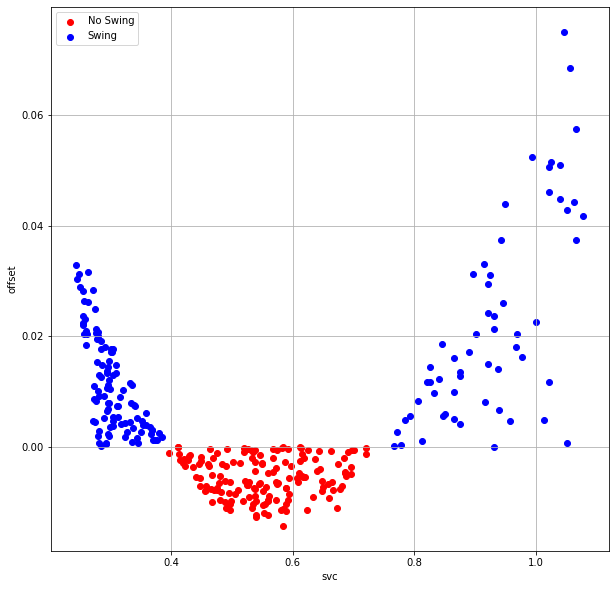

In [161]:
# dfc["threshold"] = -1*(\
#     1.00 * 0.175 + \
#     -0.65 * dfc["ruth_vibes"] + \
#     -0.27 * dfc["path_scaled"] + \
#     0.27 * dfc["mox_scaled"] + \
#     -0.20 * dfc["ballpark_viscosity"] + \
#     0.04 * dfc["mox_vibes"] + \
#     0.008 * dfc["path_vibes"])
# dfc["threshold"] = -1 * (\
#     coef_scaled[0,0] * intercept_scaled + \
#     coef_scaled[0,1] * dfc["ruth_vibes"] + \
#     coef_scaled[0,2] * dfc["mox_vibes"] + \
#     coef_scaled[0,3] * dfc["path_scaled"] + \
#     coef_scaled[0,4] * dfc["ballpark_viscosity"])
# dfc["threshold"] = dfc["svc"] - 0.125
dfc["threshold"] = dfc["svc"] - intercept_scaled
# dfc.loc[(dfc["threshold"] > 0.95), "threshold"] = 0.95


dfc["offset"] = dfc["roll"] - dfc["threshold"]

outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
print(len(outliers))

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
x_val = "svc"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="No Swing")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Swing")
ax.set_xlabel(x_val)
ax.set_ylabel('offset')
ax.grid()
ax.legend()
# ax.set_xlim(0, 1.4)
# ax.set_xlim(0.1, 0.7)
# ax.set_ylim(-0.06, 0.08)
fig.savefig("swing_fit_outliers.png", facecolor='white')

In [162]:
col_list = ['event_type',
            'roll',
            'threshold',
            'offset',
            'batter_name',
            'pitcher_name',
            'game_id',
            'play_count',
             'batter_mods']
outliers.sort_values('offset', ascending=False).loc[:, col_list]

,event_type,roll,threshold,offset,batter_name,pitcher_name,game_id,play_count,batter_mods
34695,Foul,0.945735,0.870637,0.075098,Bottles Suljak,Gabriel Griffith,38833ce8-b9fe-48a8-b2ad-d933cd3e5b95,370,NaN
15509,BaseHit,0.949269,0.880624,0.068645,Stephens Lightner,Sixpack Santiago,42ed09cd-e346-485f-b03a-e53b203c607e,249,NaN
15004,StrikeSwinging,0.947536,0.890021,0.057514,Baldwin Breadwinner,Conrad Vaughan,42ed09cd-e346-485f-b03a-e53b203c607e,73,NaN
650,StrikeSwinging,0.870692,0.818181,0.052511,Jasper Blather,Hiroto Wilcox,8ac77e5c-fa21-4403-9b67-855d6a469e92,65,WANDERER
28543,StrikeSwinging,0.901037,0.849505,0.051532,Yurts Buttercup,Qais Dogwalker,10d4a29e-b724-49b9-bdb1-ce09f2392936,166,WIRED
...,...,...,...,...,...,...,...,...,...
14991,Ball,0.364281,0.376286,-0.012005,Morrow Wilson,Mullen Peterson,5ffd315d-53ba-4f1a-aa1a-e74c308fa6a3,66,NaN
53242,Ball,0.371599,0.383887,-0.012288,Rat Mason,Mummy Melcon,e6785009-d77a-444f-9056-85d56a7d85be,87,NaN
27113,Ball,0.351048,0.363428,-0.012380,Pedro Davids,Oscar Vaughan,6b62ad47-4a1a-4c98-b506-f5281705761d,288,FLINCH
8165,Ball,0.351633,0.364282,-0.012649,Elwin McGhee,Silvia Rugrat,61726359-ac29-4150-8997-417cb97a8015,26,NaN


In [163]:
# let's do *another svc* but polynomial this time
Xp = dfc[['roll', 'svc']]

scp = StandardScaler()
Xp2 = scp.fit_transform(Xp)

trainedsvm_p = svm.SVC(kernel='poly', degree=3, max_iter=1000000, C=1000).fit(Xp2, y)
predictionsvm_p = trainedsvm_p.predict(Xp2)
print(confusion_matrix(y,predictionsvm_p))
print(classification_report(y,predictionsvm_p))

[[21833    12]
 [   10  6951]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21845
        True       1.00      1.00      1.00      6961

    accuracy                           1.00     28806
   macro avg       1.00      1.00      1.00     28806
weighted avg       1.00      1.00      1.00     28806



In [164]:
trainedsvm_p.intercept_

array([-38.09269388])

In [165]:
swings = dfc[dfc['passed']]
looks = dfc[~dfc['passed']]

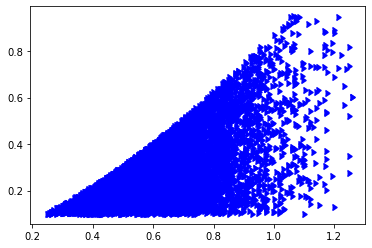

In [166]:
plt.scatter(swings[x_val], swings["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
# plt.plot(x, series_s(x),'k')

In [167]:
swings['svc'].min()

0.24333971572483798

In [168]:
x = np.arange(0.24, 0.8, 0.01)
y_s = np.zeros(x.shape)
y_l = np.zeros(x.shape)
for i, n in enumerate(x):
    y_s[i] = swings[((swings['svc'] > n) & (swings['svc'] <= n + 0.01))]['roll'].max()
    y_l[i] = looks[((looks['svc'] > n) & (looks['svc'] <= n + 0.01))]['roll'].min()

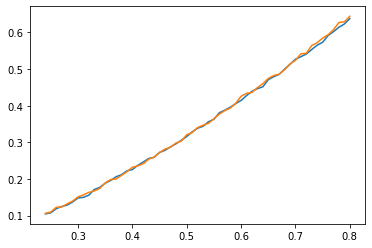

In [169]:
plt.plot(x, y_s)
plt.plot(x, y_l)

In [172]:
from numpy.polynomial import Polynomial

series_s = Polynomial.fit(x, y_s, 2)
series_l = Polynomial.fit(x, y_l, 2)

In [173]:
series_s.coef

array([0.33627811, 0.26748669, 0.03263712])

In [174]:
series_l.coef

array([0.33637156, 0.27015512, 0.03824312])

In [176]:
print(series_s)
print(series_l)

0.3362781055919802 + 0.26748668796832564·x¹ + 0.032637124519916225·x²
0.33637156480682756 + 0.2701551217009283·x¹ + 0.03824311761517129·x²
